In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
import numpy              as np
import plotly.express       as px
import pydotplus         as pdp
import seaborn as sns
from scipy import stats
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics          import mean_absolute_error, mean_squared_error
from IPython.display         import Image
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics          import accuracy_score, confusion_matrix
from sklearn.metrics          import auc,roc_curve
from sklearn.metrics          import precision_score, recall_score, f1_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
from scipy.stats.mstats import winsorize

from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression


### LOADING DATASETS

In [2]:
df3 = pd.read_csv('./data/paris_weekdays.csv')
df4 = pd.read_csv('./data/paris_weekends.csv')

df3['weekends'] = 0
df4['weekends'] = 1

d = [df3, df4]
df = pd.concat(d, axis= 0)
df = df.rename(columns= {df.columns[0]: 'ID'})
df.drop(['ID', 'attr_index_norm', 'rest_index_norm'], axis=1, inplace=True)
df

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,rest_index,lng,lat,weekends
0,296.159940,Private room,False,True,2.0,True,0,0,10.0,97.0,1,0.699821,0.193709,518.478947,1218.662228,2.35385,48.86282,0
1,288.237487,Private room,False,True,2.0,True,0,0,10.0,97.0,1,2.100005,0.107221,873.216962,1000.543327,2.32436,48.85902,0
2,211.343089,Private room,False,True,2.0,False,0,0,10.0,94.0,1,3.302325,0.234724,444.556077,902.854467,2.31714,48.87475,0
3,298.956100,Entire home/apt,False,False,2.0,False,0,1,9.0,91.0,1,0.547567,0.195997,542.142014,1199.184166,2.35600,48.86100,0
4,247.926181,Entire home/apt,False,False,4.0,False,0,0,7.0,82.0,1,1.197921,0.103573,406.928958,1070.775497,2.35915,48.86648,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3553,295.460900,Entire home/apt,False,False,4.0,False,0,0,9.0,80.0,1,3.660389,0.168146,209.752453,540.326583,2.38051,48.88393,1
3554,232.081275,Entire home/apt,False,False,4.0,False,0,0,10.0,98.0,1,3.558813,0.154703,185.486701,474.351813,2.40050,48.85093,1
3555,223.925809,Entire home/apt,False,False,2.0,False,1,0,9.0,89.0,1,4.205205,0.253029,172.658919,406.585935,2.40100,48.87700,1
3556,200.857489,Entire home/apt,False,False,2.0,True,0,0,9.0,93.0,1,2.891214,0.240674,235.167925,602.451672,2.38200,48.87400,1


In [ ]:
continuous_cols = ['realSum', 'guest_satisfaction_overall',
                 'dist','metro_dist', 'attr_index','rest_index', 'lng', 'lat']
discrete_cols = ['person_capacity', 'cleanliness_rating', 'bedrooms' ]
binary_cols = ['room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz', 'weekends']
nominal_cols = ['room_type']
bool_cols = ['room_shared', 'room_private', 'host_is_superhost']

num_cols = continuous_cols + discrete_cols

### PREPROCESSING

#### Handling Skewness

In [ ]:
def auto_transform_skewed(df, numeric_cols, skew_threshold=0.5):
    """
    Detect and handle skewness
    - Box-Cox if skew > threshold and > 0
    - Yeo-Johnson if skew > threshold and <= 0
    - Power transform if skew < - threshold
    
    """
    transform_summary = {}

    for col in numeric_cols:
        skew = df[col].skew()
        method = None

        if abs(skew) < skew_threshold:
            continue

        # right skew
        if skew > skew_threshold:
            if (df[col] > 0).all():
                df[col], _ = stats.boxcox(df[col])
                method = 'Box-Cox'
            else:
                pt = PowerTransformer(method='yeo-johnson')
                df[col] = pt.fit_transform(df[[col]])
                method = 'Yeo-Johnson'
            print(f"{col}: skew={skew:.2f}: right skew → dùng {method}")

        # left skew
        elif skew < -skew_threshold:
            # Power transform ngược lại (flip sign rồi transform)
            flipped = -df[col] + df[col].max() + 1
            pt = PowerTransformer(method='yeo-johnson')
            df[col] = -pt.fit_transform(flipped.to_frame())
            method = 'Power transform (left skew)'
            print(f"{col}: skew={skew:.2f}: left skew → dùng {method}")

        transform_summary[col] = {'skew_before': skew, 'method': method}

    return df, pd.DataFrame(transform_summary).T

In [ ]:
df['x'] = np.cos(np.radians(df['lat'])) * np.cos(np.radians(df['lng']))
df['y'] = np.cos(np.radians(df['lat'])) * np.sin(np.radians(df['lng']))
df['z'] = np.sin(np.radians(df['lat']))

df = df.drop(['lng', 'lat'], axis= 1)

In [ ]:
encoder_1 = LabelEncoder()
df['room_type'] =  encoder_1.fit_transform(df['room_type'])

df[bool_cols] = df[bool_cols].astype(int)

In [ ]:
df_clf = df.copy()

df.shape

(6688, 19)

#### Classes Identification

In [ ]:
# Tính trung vị của giá
median_price = df_clf['realSum'].median()

# Hàm phân loại 2 nhóm giá
def classify_price(x):
    if x <= median_price:
        return 'Thấp'
    else:
        return 'Cao'

In [ ]:
# Tạo cột nhãn
df_clf['price_group'] = df_clf['realSum'].apply(classify_price)

encoder = OrdinalEncoder()
df_clf[['room_type']] = encoder.fit_transform(df_clf[['room_type']])

In [ ]:
# Tạo tập dữ liệu
X = df_clf.drop(['realSum', 'price_group'], axis=1)
y = df_clf['price_group']

In [ ]:
numeric_cols = df_clf.select_dtypes(include = ['float64', 'int64'])
df_clf, summary = auto_transform_skewed(df_clf, numeric_cols)

realSum: skew=19.41: right skew → dùng Box-Cox
room_type: skew=1.52: right skew → dùng Yeo-Johnson
room_shared: skew=8.26: right skew → dùng Yeo-Johnson
room_private: skew=1.29: right skew → dùng Yeo-Johnson
person_capacity: skew=0.99: right skew → dùng Box-Cox
host_is_superhost: skew=2.07: right skew → dùng Yeo-Johnson
multi: skew=1.36: right skew → dùng Yeo-Johnson
biz: skew=1.18: right skew → dùng Yeo-Johnson
cleanliness_rating: skew=-2.25: left skew → dùng Power transform (left skew)
guest_satisfaction_overall: skew=-2.72: left skew → dùng Power transform (left skew)
bedrooms: skew=0.67: right skew → dùng Yeo-Johnson
metro_dist: skew=1.30: right skew → dùng Box-Cox
attr_index: skew=1.84: right skew → dùng Box-Cox


### UNIVARIATE TREE

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### Training with Best Hyperparameters using GridSearchCV

In [ ]:
param_grid = {
    'max_depth': [4, 6, 8, 10, None],
    'min_samples_leaf': [5, 10, 20, 30],
    'criterion': ['gini'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Cross-validation accuracy:", round(grid_search.best_score_, 3))

Best parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5}
Cross-validation accuracy: 0.787


In [ ]:
# Huấn luyện CART với tham số tối ưu
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

In [ ]:
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)

print("HIỆU SUẤT TRÊN TẬP TRAIN")
print("Accuracy (Train):", round(accuracy_score(y_train, y_train_pred), 3))
print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train, y_train_pred))

print("\nHIỆU SUẤT TRÊN TẬP TEST")
print("Accuracy (Test):", round(accuracy_score(y_test, y_test_pred), 3))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))

HIỆU SUẤT TRÊN TẬP TRAIN
Accuracy (Train): 0.915

Classification Report (Train):
               precision    recall  f1-score   support

         Cao       0.90      0.93      0.92      2338
        Thấp       0.93      0.90      0.91      2343

    accuracy                           0.92      4681
   macro avg       0.92      0.92      0.92      4681
weighted avg       0.92      0.92      0.92      4681

Confusion Matrix (Train):
 [[2171  167]
 [ 230 2113]]

HIỆU SUẤT TRÊN TẬP TEST
Accuracy (Test): 0.791

Classification Report (Test):
               precision    recall  f1-score   support

         Cao       0.78      0.81      0.79      1002
        Thấp       0.80      0.78      0.79      1005

    accuracy                           0.79      2007
   macro avg       0.79      0.79      0.79      2007
weighted avg       0.79      0.79      0.79      2007

Confusion Matrix (Test):
 [[808 194]
 [225 780]]


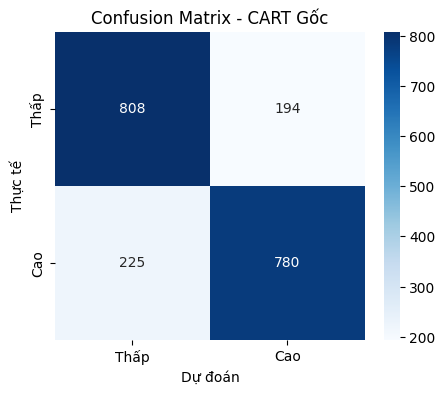

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Thấp', 'Cao'],
                yticklabels=['Thấp', 'Cao'])
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title(title)
    plt.show()

plot_confusion_matrix(y_test, y_test_pred, 'Confusion Matrix - CART Gốc')

#### Pruning

In [ ]:
# Lấy giá trị alpha có thể tỉa
path = best_clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]  # bỏ alpha cuối vì sẽ tỉa toàn bộ cây

train_scores = []
test_scores = []

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(
        random_state=42,
        criterion=grid_search.best_params_['criterion'],
        class_weight=grid_search.best_params_['class_weight'],
        max_depth=grid_search.best_params_['max_depth'],
        min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
        ccp_alpha=alpha
    )
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

In [ ]:
# Chọn alpha tốt nhất (max test accuracy)
best_alpha = ccp_alphas[np.argmax(test_scores)]
print("Best ccp_alpha:", round(best_alpha, 5))

Best ccp_alpha: 0.00069


#### Retrain


In [ ]:
# Huấn luyện lại mô hình với alpha tối ưu
pruned_clf = DecisionTreeClassifier(
    random_state=42,
    criterion=grid_search.best_params_['criterion'],
    class_weight=grid_search.best_params_['class_weight'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    ccp_alpha=best_alpha
)
pruned_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=np.float64(0.0006853413976930503),
                       min_samples_leaf=5, random_state=42)

In [ ]:
y_train_pred_pruned = pruned_clf.predict(X_train)
y_test_pred_pruned = pruned_clf.predict(X_test)

print("HIỆU SUẤT TRÊN TẬP TRAIN (PRUNED TREE)")
print("Train Accuracy:", round(accuracy_score(y_train, y_train_pred_pruned), 3))
print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred_pruned))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train, y_train_pred_pruned))

print("\nHIỆU SUẤT TRÊN TẬP TEST (PRUNED TREE)")
print("Test Accuracy:", round(accuracy_score(y_test, y_test_pred_pruned), 3))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred_pruned))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred_pruned))

HIỆU SUẤT TRÊN TẬP TRAIN (PRUNED TREE)
Train Accuracy: 0.878

Classification Report (Train):
               precision    recall  f1-score   support

         Cao       0.87      0.88      0.88      2338
        Thấp       0.88      0.87      0.88      2343

    accuracy                           0.88      4681
   macro avg       0.88      0.88      0.88      4681
weighted avg       0.88      0.88      0.88      4681

Confusion Matrix (Train):
 [[2068  270]
 [ 300 2043]]

HIỆU SUẤT TRÊN TẬP TEST (PRUNED TREE)
Test Accuracy: 0.813

Classification Report (Test):
               precision    recall  f1-score   support

         Cao       0.81      0.81      0.81      1002
        Thấp       0.81      0.81      0.81      1005

    accuracy                           0.81      2007
   macro avg       0.81      0.81      0.81      2007
weighted avg       0.81      0.81      0.81      2007

Confusion Matrix (Test):
 [[815 187]
 [189 816]]


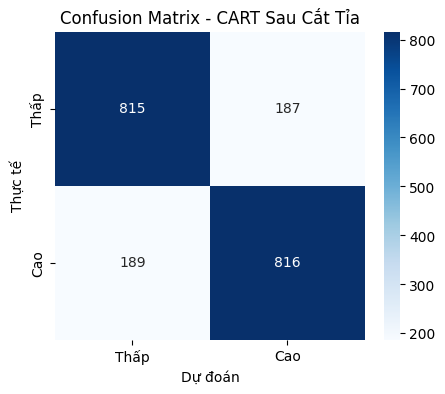

In [ ]:
plot_confusion_matrix(y_test, y_test_pred_pruned, 'Confusion Matrix - CART Sau Cắt Tỉa')

#### Feature Importance


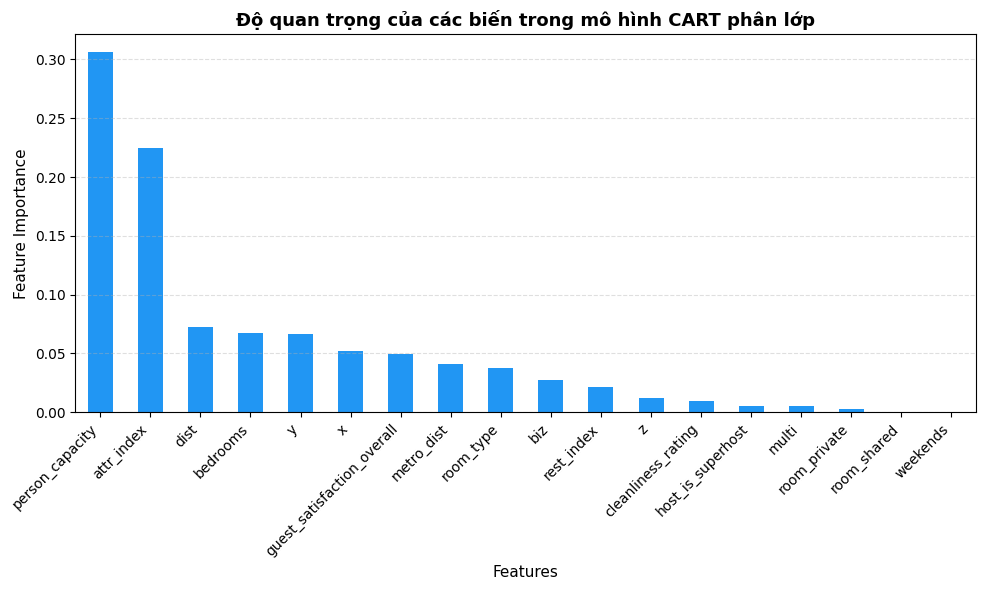

In [ ]:
importances = pd.Series(pruned_clf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10,6), color = '#2196F3')

plt.title('Độ quan trọng của các biến trong mô hình CART phân lớp', fontsize=13, fontweight='bold')
plt.xlabel('Features', fontsize=11)
plt.ylabel('Feature Importance', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

### MULTIVARIATE TREE

In [ ]:
df2 = df_clf.copy()
encoder = OrdinalEncoder()
df2[['price_group']] = encoder.fit_transform(df2[['price_group']])

In [ ]:
continuous_cols = ['realSum', 'guest_satisfaction_overall',
                 'dist','metro_dist', 'attr_index','rest_index', 'x', 'y', 'z']
discrete_cols = ['person_capacity', 'cleanliness_rating', 'bedrooms' ]
binary_cols = ['room_shared', 'room_private', 'host_is_superhost', 'multi', 'biz']
nominal_cols = ['room_type', 'city']

#### Feature Combination

<Axes: >

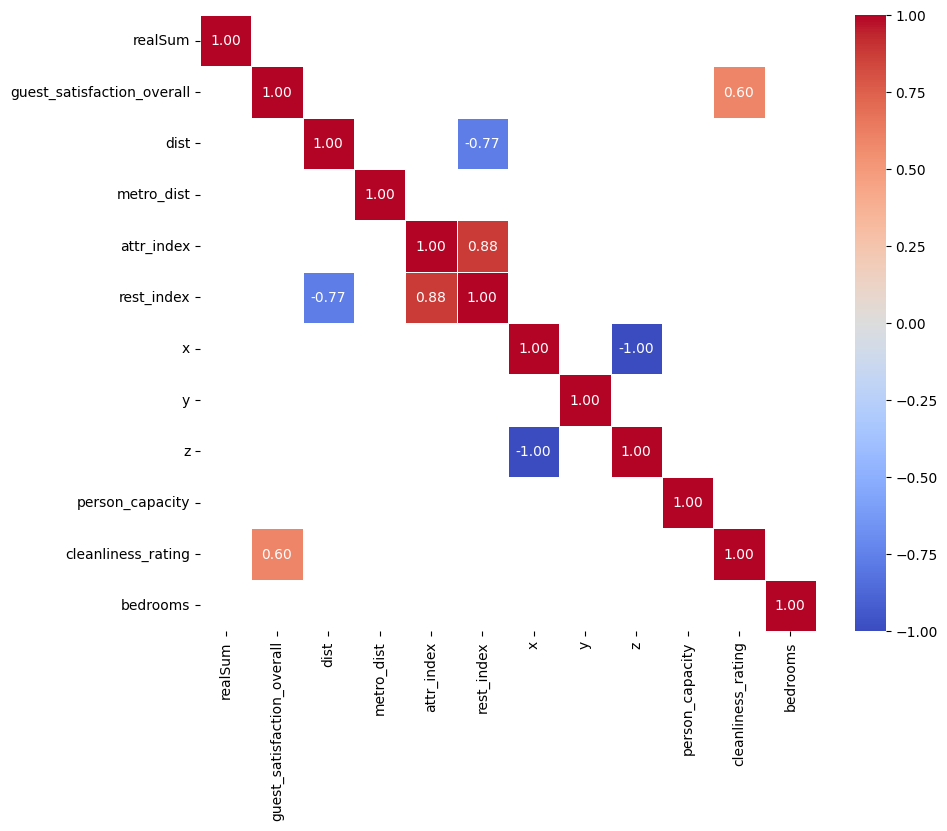

In [ ]:
num_cols = continuous_cols + discrete_cols
num_mtrx = df2[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    num_mtrx[abs(num_mtrx) > 0.6],
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True
)

In [ ]:
pair_1 = ['rest_index', 'attr_index', 'dist']
pair_2 = ['cleanliness_rating', 'guest_satisfaction_overall']

In [ ]:
# --- 1: Assign weights based on correlation ---
def get_corr_weights(df, features, target):
    corr = df[features + [target]].corr()[target].abs()
    corr = corr.drop(target)
    weights = corr / corr.sum()
    return weights.to_dict()

# --- 2: Assign weights based on feature importance ---
def get_tree_weights(df, features, target):
    X = df[features]
    y = df[target]
    tree = DecisionTreeRegressor(max_depth=5, random_state=42)
    tree.fit(X, y)
    imp = tree.feature_importances_
    weights = imp / imp.sum()
    return dict(zip(features, weights))

# --- 3: Assign weights based on OLS ---
def get_ols_weights(df, features, target):
    X = df[features]
    y = df[target]
    model = LinearRegression().fit(X, y)
    coef = np.abs(model.coef_)
    weights = coef / coef.sum()
    return dict(zip(features, weights))


available_methods = ['corr', 'tree', 'ols']
method_choice = input(f"Nhập phương pháp ({', '.join(available_methods)}): ").strip().lower()

if method_choice == 'corr':
    weights_1 = get_corr_weights(df2, pair_1, 'realSum')
    weights_2 = get_corr_weights(df2, pair_2, 'realSum')
elif method_choice == 'tree':
    weights_1 = get_tree_weights(df2, pair_1, 'realSum')
    weights_2 = get_tree_weights(df2, pair_2, 'realSum')
elif method_choice == 'ols':
    weights_1 = get_ols_weights(df2, pair_1, 'realSum')
    weights_2 = get_ols_weights(df2, pair_2, 'realSum')
else: 
    weights_1 = get_ols_weights(df2, pair_1, 'realSum')
    weights_2 = get_ols_weights(df2, pair_2, 'realSum')



df2['location_score'] = (
    weights_1['rest_index'] * df2['rest_index'] +
    weights_1['attr_index'] * df2['attr_index'] -
    weights_1['dist'] * df2['dist']  # dist nghịch biến
)

df2['quality_score'] = (
    weights_2['cleanliness_rating'] * df2['cleanliness_rating'] +
    weights_2['guest_satisfaction_overall'] * df2['guest_satisfaction_overall']
)

df2.drop(columns=pair_1 + pair_2, inplace=True)

print(df2[['location_score', 'quality_score']].head())

Nhập phương pháp (corr, tree, ols): ols
   location_score  quality_score
0        3.306016       0.762671
1        3.409536       0.762671
2        3.244668       0.554590
3        3.317652      -0.627770
4        3.241366      -1.534425


In [ ]:
X2 = df2.drop(['realSum', 'price_group'], axis=1, inplace=False)
y2 = df2[['price_group']]

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=81)

#### Training with Best HyperParameters using GridSearchCV


In [ ]:
# Tìm tham số tốt nhất cho CART
param_grid = {
    'max_depth': [4, 6, 8, 10, None],
    'min_samples_leaf': [5, 10, 20, 30],
    'criterion': ['gini'],
    'class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train2, y_train2)

print("Best parameters:", grid_search.best_params_)
print("Cross-validation accuracy:", round(grid_search.best_score_, 3))

Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 5}
Cross-validation accuracy: 0.797


In [ ]:
best_clf2 = grid_search.best_estimator_
best_clf2.fit(X_train2, y_train2)

DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=5,
                       random_state=42)

In [ ]:
# Đánh giá mô hình
y_train_pred2 = best_clf2.predict(X_train2)
y_test_pred2 = best_clf2.predict(X_test2)

# HIỆU SUẤT TRÊN TẬP HUẤN LUYỆN
print("HIỆU SUẤT TRÊN TẬP TRAIN")
print("Accuracy (Train):", round(accuracy_score(y_train2, y_train_pred2), 3))
print("\nClassification Report (Train):\n", classification_report(y_train2, y_train_pred2))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train2, y_train_pred2))

# HIỆU SUẤT TRÊN TẬP KIỂM TRA
print("\nHIỆU SUẤT TRÊN TẬP TEST")
print("Accuracy (Test):", round(accuracy_score(y_test2, y_test_pred2), 3))
print("\nClassification Report (Test):\n", classification_report(y_test2, y_test_pred2))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test2, y_test_pred2))

HIỆU SUẤT TRÊN TẬP TRAIN
Accuracy (Train): 0.921

Classification Report (Train):
               precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      2661
         1.0       0.92      0.92      0.92      2689

    accuracy                           0.92      5350
   macro avg       0.92      0.92      0.92      5350
weighted avg       0.92      0.92      0.92      5350

Confusion Matrix (Train):
 [[2458  203]
 [ 217 2472]]

HIỆU SUẤT TRÊN TẬP TEST
Accuracy (Test): 0.833

Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.84      0.83      0.83       679
         1.0       0.83      0.83      0.83       659

    accuracy                           0.83      1338
   macro avg       0.83      0.83      0.83      1338
weighted avg       0.83      0.83      0.83      1338

Confusion Matrix (Test):
 [[566 113]
 [111 548]]


#### Pruning

In [ ]:
# Lấy giá trị alpha có thể tỉa
path2 = best_clf2.cost_complexity_pruning_path(X_train2, y_train2)
ccp_alphas2 = path.ccp_alphas[:-1]  # bỏ alpha cuối vì sẽ tỉa toàn bộ cây

train_scores2 = []
test_scores2 = []

for alpha in ccp_alphas:
    clf2 = DecisionTreeClassifier(
        random_state=42,
        criterion=grid_search.best_params_['criterion'],
        class_weight=grid_search.best_params_['class_weight'],
        max_depth=grid_search.best_params_['max_depth'],
        min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
        ccp_alpha=alpha
    )
    clf2.fit(X_train2, y_train2)
    train_scores2.append(clf2.score(X_train2, y_train2))
    test_scores2.append(clf2.score(X_test2, y_test2))

In [ ]:
best_alpha2 = ccp_alphas2[np.argmax(test_scores2)]
print("Best ccp_alpha:", round(best_alpha2, 5))

Best ccp_alpha: 0.00028


#### Retrain

In [ ]:
# Huấn luyện lại mô hình với alpha tối ưu
pruned_clf2 = DecisionTreeClassifier(
    random_state=42,
    criterion=grid_search.best_params_['criterion'],
    class_weight=grid_search.best_params_['class_weight'],
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
    ccp_alpha=best_alpha2
)
pruned_clf2.fit(X_train2, y_train2)

DecisionTreeClassifier(ccp_alpha=np.float64(0.00028483942177597423),
                       class_weight='balanced', min_samples_leaf=5,
                       random_state=42)

In [ ]:
# Đánh giá lại
y_train_pred_pruned2 = pruned_clf2.predict(X_train2)
y_test_pred_pruned2 = pruned_clf2.predict(X_test2)

# HIỆU SUẤT TRÊN TẬP HUẤN LUYỆN
print("HIỆU SUẤT TRÊN TẬP TRAIN (PRUNED TREE)")
print("Train Accuracy:", round(accuracy_score(y_train2, y_train_pred_pruned2), 3))
print("\nClassification Report (Train):\n", classification_report(y_train2, y_train_pred_pruned2))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train2, y_train_pred_pruned2))

# HIỆU SUẤT TRÊN TẬP KIỂM TRA
print("\nHIỆU SUẤT TRÊN TẬP TEST (PRUNED TREE)")
print("Test Accuracy:", round(accuracy_score(y_test2, y_test_pred_pruned2), 3))
print("\nClassification Report (Test):\n", classification_report(y_test2, y_test_pred_pruned2))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test2, y_test_pred_pruned2))

HIỆU SUẤT TRÊN TẬP TRAIN (PRUNED TREE)
Train Accuracy: 0.917

Classification Report (Train):
               precision    recall  f1-score   support

         0.0       0.91      0.92      0.92      2661
         1.0       0.92      0.91      0.92      2689

    accuracy                           0.92      5350
   macro avg       0.92      0.92      0.92      5350
weighted avg       0.92      0.92      0.92      5350

Confusion Matrix (Train):
 [[2454  207]
 [ 238 2451]]

HIỆU SUẤT TRÊN TẬP TEST (PRUNED TREE)
Test Accuracy: 0.833

Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.84      0.83      0.84       679
         1.0       0.83      0.83      0.83       659

    accuracy                           0.83      1338
   macro avg       0.83      0.83      0.83      1338
weighted avg       0.83      0.83      0.83      1338

Confusion Matrix (Test):
 [[566 113]
 [110 549]]


### ACCURACY COMPARISON BETWEEN UNIVARIATE AND MULTIVARIATE TREE

In [ ]:
data = {
    'Phương pháp': [
        'Tương quan',
        'Features Importance',
        'OLS',
        'Cây đơn biến'
    ],
    'Accuracy_train': [88, 89.4, 91.7, 87.8],
    'Accuracy_test': [80.6, 81.8, 83.3, 81.3],
    'f1-score train' :[88, 89, 92, 88],
    'Chênh lệch train-test': [7.4, 7.4, 8.4, 6.5],
    'Chi phí ccp_alpha': [0.00039, 0.00048, 0.00028, 0.00068]
}

df = pd.DataFrame(data)

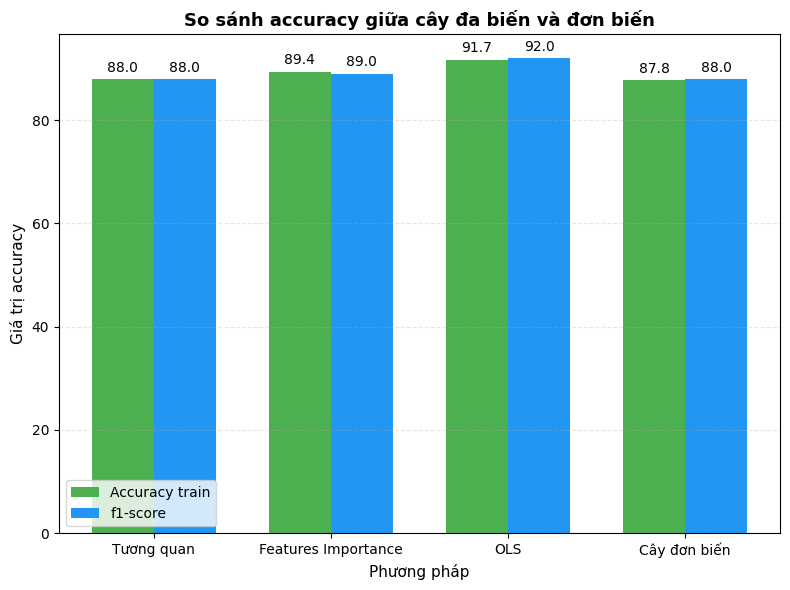

In [ ]:
x = np.arange(len(df['Phương pháp']))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))

bar1 = ax.bar(x - width/2, df['Accuracy_train'], width, label='Accuracy train', color='#4CAF50')
bar2 = ax.bar(x + width/2, df['f1-score train'], width, label='f1-score', color='#2196F3')

ax.set_title('So sánh accuracy giữa cây đa biến và đơn biến', fontsize=13, fontweight='bold')
ax.set_xlabel('Phương pháp', fontsize=11)
ax.set_ylabel('Giá trị accuracy', fontsize=11)
ax.set_xticks(x)
ax.set_xticklabels(df['Phương pháp'])
ax.legend(loc = 'lower left')
ax.grid(axis='y', linestyle='--', alpha=0.3)

for bars in [bar1, bar2]:
    ax.bar_label(bars, fmt='%.1f', fontsize=10, padding=3)

plt.tight_layout()
plt.show()

### ID3 - C4.5 - CART COMPARISON

#### Training on default hyperparameters

In [ ]:
# 1. CART (Gini)
cart_clf = DecisionTreeClassifier(
    criterion='gini',
    random_state=42
)
cart_clf.fit(X_train, y_train)
cart_pred = cart_clf.predict(X_test)
cart_acc = accuracy_score(y_test, cart_pred)

# 2. ID3 (Entropy / Information Gain)
id3_clf = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
id3_clf.fit(X_train, y_train)
id3_pred = id3_clf.predict(X_test)
id3_acc = accuracy_score(y_test, id3_pred)

# 3. C4.5 (Gain Ratio - mô phỏng bằng pruning nhẹ)
c45_clf = DecisionTreeClassifier(
    criterion='entropy',        # C4.5 cũng dựa trên entropy, nhưng cải tiến bằng gain ratio
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42
)
c45_clf.fit(X_train, y_train)
c45_pred = c45_clf.predict(X_test)
c45_acc = accuracy_score(y_test, c45_pred)

# === 4. Tổng hợp kết quả ===
results = pd.DataFrame({
    'Thuật toán': ['CART', 'ID3', 'C4.5'],
    'Accuracy': [cart_acc, id3_acc, c45_acc]
})

print("Kết quả so sánh độ chính xác giữa các mô hình cây phân lớp:")
print(results)

# --- CART Report ---
print("\n CART (Gini):")
print(classification_report(y_test, cart_pred))

# --- ID3 Report ---
print("\n ID3 (Entropy / InfoGain):")
print(classification_report(y_test, id3_pred))

# --- C4.5 Report ---
print("\n C4.5 (Gain Ratio mô phỏng):")
print(classification_report(y_test, c45_pred))

Kết quả so sánh độ chính xác giữa các mô hình cây phân lớp:
  Thuật toán  Accuracy
0       CART  0.854011
1        ID3  0.857000
2       C4.5  0.835575

 CART (Gini):
              precision    recall  f1-score   support

         Cao       0.84      0.87      0.86      1002
        Thấp       0.87      0.84      0.85      1005

    accuracy                           0.85      2007
   macro avg       0.85      0.85      0.85      2007
weighted avg       0.85      0.85      0.85      2007


 ID3 (Entropy / InfoGain):
              precision    recall  f1-score   support

         Cao       0.85      0.87      0.86      1002
        Thấp       0.87      0.84      0.85      1005

    accuracy                           0.86      2007
   macro avg       0.86      0.86      0.86      2007
weighted avg       0.86      0.86      0.86      2007


 C4.5 (Gain Ratio mô phỏng):
              precision    recall  f1-score   support

         Cao       0.82      0.86      0.84      1002
        Thấp

In [ ]:
data = {
    'Thuật toán': ['CART', 'ID3', 'C4.5'],
    'Accuracy': [0.854, 0.857, 0.835],
    'Precision': [0.85, 0.86, 0.84],
    'F1-score': [0.85, 0.86, 0.84]
}

df_cls = pd.DataFrame(data)
print(df_cls)

  Thuật toán  Accuracy  Precision  F1-score
0       CART     0.854       0.85      0.85
1        ID3     0.857       0.86      0.86
2       C4.5     0.835       0.84      0.84


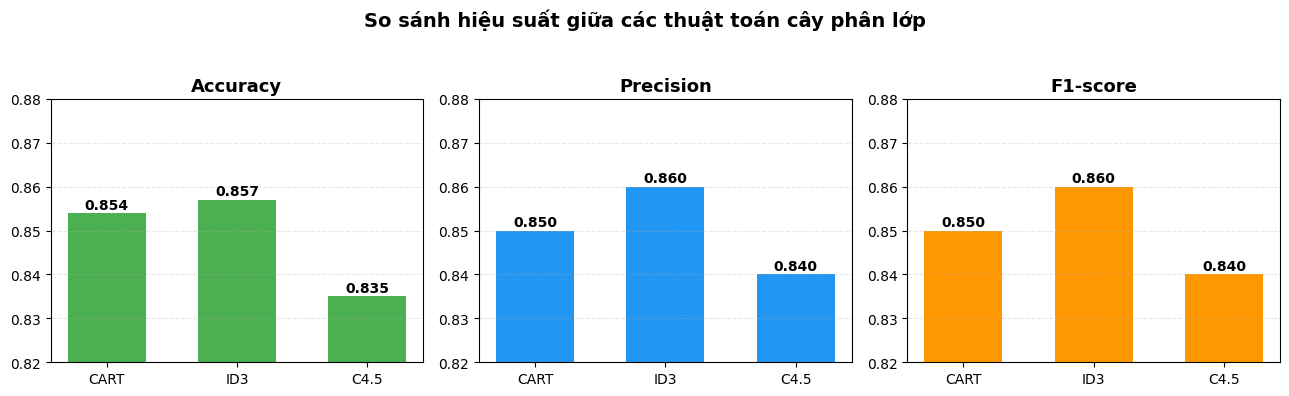

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

metrics = ['Accuracy', 'Precision', 'F1-score']
colors = ['#4CAF50', '#2196F3', '#FF9800']

for i, metric in enumerate(metrics):
    axes[i].bar(df_cls['Thuật toán'], df_cls[metric], color=colors[i], width=0.6)
    axes[i].set_title(metric, fontsize=13, fontweight='bold')
    axes[i].set_ylim(0.82, 0.88)  # cố định trục y cho dễ so sánh
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)

    # Hiển thị giá trị trên đầu cột
    for idx, val in enumerate(df_cls[metric]):
        axes[i].text(idx, val + 0.001, f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

fig.suptitle('So sánh hiệu suất giữa các thuật toán cây phân lớp', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()